Rect_filter fuc ...
The number of rect is 1 after area filter


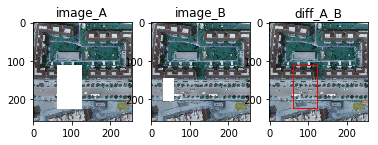

In [19]:
#coding=utf-8
# main

import json 
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from pygeotile.tile import Tile
import math
from copy import *
from math import *
import os

def bounds(x,y,z):
    t=Tile.from_google(x,y,z)
    sw_min,ne_max=t.bounds
    latSw=sw_min[0]
    lngSw=sw_min[1]
    latNe=ne_max[0]
    lngNe=ne_max[1]
    return latSw,lngSw,latNe,lngNe

def get_gps(latSw,lngSw,latNe,lngNe,pixel_len):
    start_lat=latSw
    start_lng=lngNe
    end_lat=latNe
    end_lng=lngSw
    
    #pixel_len=math.sqrt(math.pow(256,2)+math.pow(256,2))
    delta_lat=abs(start_lat-end_lat)
    delta_lng=abs(start_lng-end_lng)

    lat_2_pixel=pixel_len/delta_lat
    lng_2_pixel=pixel_len/delta_lng
    return lat_2_pixel,lng_2_pixel,start_lat, start_lng

def point_2_pixel(lat,lng):
    width=abs(lat-start_lat)*lat_2_pixel 
    hight=abs(lng-start_lng)*lng_2_pixel
    x= width
    y=hight
    return x,y

def pixel_2_point(x,y):
    lat=x/lat_2_pixel+start_lat
    lng=y/lng_2_pixel+start_lng
    return lat,lng


def draw_box(bounds,img_empty_rect,color):
    if color==0:
        box=np.int0(bounds)
        cv2.drawContours(img_empty_rect,[box],-1,(255,255,255),-1)
        return img_empty_rect
    else:
        box=np.int0(bounds)
        cv2.drawContours(img_empty_rect,[box],-1,(255,0,0),2)
        return img_empty_rect



def load_json(json_path):
    file_=open(json_path)

    file_np=json.load(file_)#dict
    bbox=file_np['bounds']
    N=len(bbox)
    rect=[]
    #rect=[[[0 for i in range(N)] for j in range(4)] for k in range (2)]#np.zeros((N,4,2),dtype=float)
    #print point_2_pixel(30.89633279665858,121.89743041992186)#0,0
    #print point_2_pixel(30.897511207369128,121.89605712890624)#256,256
    for i in range(0,N):
        if bbox[i]['label']=='building':
            rect_dict=bbox[i]['bbox']
            rect_=[]
            for j in range(0,4):
                x,y,=point_2_pixel( lat=rect_dict[j]['lat'],lng=rect_dict[j]['lng'])
                rect_.append([x,y])
            rect.append(rect_)
            #print rect
    return rect




def process(x,y,z,json_path,image):
    #convert xyz to tile's bound lat/long
    latSw,lngSw,latNe,lngNe=bounds(x,y,z)
    #lat/long to pixel
    global lat_2_pixel,lng_2_pixel,start_lat, start_lng
    lat_2_pixel,lng_2_pixel,start_lat, start_lng=get_gps(latSw,lngSw,latNe,lngNe,pixel_len=256)

    ##
    #load json
    rect=load_json(json_path)  

    #draw boxes
    img_empty_rect= np.zeros((256, 256), dtype=np.uint8)  
    for i in range(2):#np.array(rect).shape[0]
        box_=draw_box(rect[i],img_empty_rect,0)
        img_=draw_box(rect[i],image,0)
        
    return box_,img_



def matchAB(imageA, imageB):
    grayA=imageA
    grayB=imageB
    #grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    #grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

 # 获取图片A的大小
    height, width = grayA.shape
 # 取局部图像，寻找匹配位置
    result_window = np.zeros((height, width), dtype=grayA.dtype)
    for start_y in range(0, height-250, 50): # window size and step
        for start_x in range(0, width-250, 50):
            window = grayA[start_y:start_y+250, start_x:start_x+250]
            match = cv2.matchTemplate(grayB, window, cv2.TM_CCOEFF_NORMED)
            _, _, _, max_loc = cv2.minMaxLoc(match)
            matched_window = grayB[max_loc[1]:max_loc[1]+250, max_loc[0]:max_loc[0]+250]
            result = cv2.absdiff(window, matched_window)
            result_window[start_y:start_y+250, start_x:start_x+250] = result
            
    #plt.imshow(result_window)
    #plt.savefig("A_B_match_result.png")
    #cv2.imwrite('result.png',result_window)
    #plt.show()
    return result_window

def Rect_filter(contours,down):
    print 'Rect_filter fuc ...'
    N= np.array(contours).shape[0]
    contours_update=[]
    Rect_update=[]
    count=0
    for i in range (0,N):
        Rect=cv2.minAreaRect(contours[i])
        Area_=Rect[1][0]*Rect[1][1]
        if Area_ >=down:# and (Rect[1][1]<300):
            contours_update.append(contours[i])
            Rect_update.append(Rect)
            count=count+1
    print "The number of rect is {} after area filter".format(count)
    return contours_update,Rect_update


def diff_filter(matched_result,origin_image,down):
    diff_box=[]
    #if diff area is biger than theshold then draw as addition building on origion image
    binary,contours,hierarchy=cv2.findContours(matched_result,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    contours_update,Rect_update=Rect_filter(contours,down)
    #extract the diff's contours minAreaRect box=diff box
    for rect_i in Rect_update:
        #print rect_i
        diff_box=cv2.boxPoints(rect_i)
        image=draw_box(diff_box,origin_image,color=1)
    return image
    

################ main
x,y,z=[219834,107396,18]
origin_path='189_x=219834_y=107396.png'

json_path_early="a.json"
json_path_later="b.json"
origin_image=cv2.imread(origin_path)
#copy
img_a=copy(origin_image)
img_b=copy(origin_image)
img_out=copy(origin_image)
#cv2.imshow('',origin_image)
#cv2.waitKey(0)
mask_early,img_early=process(x,y,z,json_path_early,img_a)
mask_later,img_later=process(x,y,z,json_path_later,img_b)

fig=plt.figure()
fig.add_subplot(1,3,1,title='image_A')
cv2.imwrite('A.png',img_early)
plt.imshow(img_early)

fig.add_subplot(1,3,2,title='image_B')
cv2.imwrite('B.png',img_later)
plt.imshow(img_later)

matched_result=matchAB(mask_early,mask_later)


diff=diff_filter(matched_result,img_out,down=1500)# 
fig.add_subplot(1,3,3,title='diff_A_B')
plt.imshow(diff)
cv2.imwrite("A_B_diff.png",diff)
plt.show()
#cv2.imshow('',diff)
#cv2.waitKey(0)



In [ ]:
## test

import math
import pygeotile
from pygeotile.tile import Tile


def point_2_pixel(lat,lng):
    width=abs(lat-start_lat)*lat_2_pixel 
    hight=abs(lng-start_lng)*lng_2_pixel
    x= width
    y=hight
    return x,y

def pixel_2_point(x,y):
    lat=x/lat_2_pixel+start_lat
    lng=y/lng_2_pixel+start_lng
    return lat,lng

t=Tile.from_google(219834,107396,18)
sw_min,ne_max=t.bounds

print sw_min,ne_max
    
    

In [ ]:
#test for google to gps
from math import *

def tile_boundaries(x,y,z):
    pi = 3.14159
    alon1 = (x /pow(2,z))*360.0 - 180.0
    alon2 = ((x+1) /pow(2,z))*360.0 - 180.0

    an   = pi-2*pi*y/pow(2,z)
    alat1 = 180.0/pi*atan(0.5*(exp(an)-exp(-an)))
    an   = pi-2*pi*(y+1)/pow(2,z)
    alat2 = 180.0/pi*atan(0.5*(exp(an)-exp(-an)))
    
    latSw=alat1
    lngSw=alon2
    latNe=alat2
    lngNe=alon1
    
    return alat2,alon1,alat1,alon2

latSw,lngSw,latNe,lngNe =tile_boundaries(219836,107413,18)
print latSw,lngSw,latNe,lngNe
print (latSw+latNe)/2, (lngSw+lngNe)/2

In [ ]:
##test for match template

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot,savefig
import cv2
import numpy as np


def matchAB(fileA, fileB):
    # 读取图像数据
    imgA = cv2.imread(fileA)
    imgB = cv2.imread(fileB)
 # 转换成灰色
    grayA = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)
    #cv2.imwrite('gray.png',grayA)
 # 获取图片A的大小
    height, width = grayA.shape
 # 取局部图像，寻找匹配位置
    result_window = np.zeros((height, width), dtype=imgA.dtype)
    for start_y in range(0, height-255, 50): # window size and step
        for start_x in range(0, width-255, 50):
            window = grayA[start_y:start_y+255, start_x:start_x+255]
            match = cv2.matchTemplate(grayB, window, cv2.TM_CCOEFF_NORMED)
            _, _, _, max_loc = cv2.minMaxLoc(match)
            matched_window = grayB[max_loc[1]:max_loc[1]+255, max_loc[0]:max_loc[0]+255]
            result = cv2.absdiff(window, matched_window)
            result_window[start_y:start_y+255, start_x:start_x+255] = result
            
    plt.imshow(result_window)
    plt.savefig("match_result.png")
    #cv2.imwrite('result.png',result_window)
    #plt.show()
    return result_window

matchAB("a.png", "b.png")


    



In [ ]:
### test for draw json box on origin image
#output box.png

import json 
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from pygeotile.tile import Tile
import math
from math import *
import os

def bounds(x,y,z):
    t=Tile.from_google(x,y,z)
    sw_min,ne_max=t.bounds
    latSw=sw_min[0]
    lngSw=sw_min[1]
    latNe=ne_max[0]
    lngNe=ne_max[1]
    return latSw,lngSw,latNe,lngNe

def get_gps(latSw,lngSw,latNe,lngNe,pixel_len):
    start_lat=latSw
    start_lng=lngNe
    end_lat=latNe
    end_lng=lngSw
    
    #pixel_len=math.sqrt(math.pow(256,2)+math.pow(256,2))
    delta_lat=abs(start_lat-end_lat)
    delta_lng=abs(start_lng-end_lng)

    lat_2_pixel=pixel_len/delta_lat
    lng_2_pixel=pixel_len/delta_lng
    return lat_2_pixel,lng_2_pixel,start_lat, start_lng

def point_2_pixel(lat,lng):
    width=abs(lat-start_lat)*lat_2_pixel 
    hight=abs(lng-start_lng)*lng_2_pixel
    x= width
    y=hight
    return x,y

def pixel_2_point(x,y):
    lat=x/lat_2_pixel+start_lat
    lng=y/lng_2_pixel+start_lng
    return lat,lng


def draw_box(bounds,img_empty_rect,color):
    if color==0:
        box=np.int0(bounds)
        cv2.drawContours(img_empty_rect,[box],-1,(255,255,255),-1)
        return img_empty_rect
    else:
        box=np.int0(bounds)
        cv2.drawContours(img_empty_rect,[box],-1,(255,0,0),2)
        cv2.imwrite('box.png',img_empty_rect)
        plt.imshow(img_empty_rect)
        return img_empty_rect



def load_json(json_path):
    file_=open(json_path)

    file_np=json.load(file_)#dict
    bbox=file_np['bounds']
    N=len(bbox)
    rect=[]
    #rect=[[[0 for i in range(N)] for j in range(4)] for k in range (2)]#np.zeros((N,4,2),dtype=float)
    #print point_2_pixel(30.89633279665858,121.89743041992186)#0,0
    #print point_2_pixel(30.897511207369128,121.89605712890624)#256,256
    for i in range(0,N):
        if bbox[i]['label']=='building':
            rect_dict=bbox[i]['bbox']
            rect_=[]
            for j in range(0,4):
                x,y,=point_2_pixel( lat=rect_dict[j]['lat'],lng=rect_dict[j]['lng'])
                rect_.append([x,y])
            rect.append(rect_)
            #print rect
    return rect




def process(x,y,z,json_path,image_path):
    origin_image=cv2.imread(image_path)
    #convert xyz to tile's bound lat/long
    latSw,lngSw,latNe,lngNe=bounds(x,y,z)
    #lat/long to pixel
    global lat_2_pixel,lng_2_pixel,start_lat, start_lng
    lat_2_pixel,lng_2_pixel,start_lat, start_lng=get_gps(latSw,lngSw,latNe,lngNe,pixel_len=256)

    ##
    #load json
    rect=load_json(json_path)  

    #draw boxes
    img_empty_rect= np.zeros((256, 256), dtype=np.uint8)  
    for i in range(np.array(rect).shape[0]):#np.array(rect).shape[0]
        img_box=draw_box(rect[i],origin_image,1)
        
    return img_box



x,y,z=[219834,107396,18]
image_path='189_x=219834_y=107396.png'
json_path="154_x=219834_y=107396.json"

image_with_box=process(x,y,z,json_path,image_path)
